In [10]:
import os
import pandas as pd
from Bio.PDB import Chain, PDBParser, PDBIO, Polypeptide

dir = "C:/Users/mihar/Desktop/MPBF/ATLAS_downloads/ATLAS"

mol_n = len(os.listdir(dir))
atlas_data = {}

for mol_dir in os.listdir(dir):
    b_factor = plddt = rmsf = rmsf1 = rmsf2 = rmsf3 = gyr_R1 = gyr_R2 = gyr_R3 = None
    file_dir = f'{dir}/{mol_dir}/analysis'
    for file in os.listdir(file_dir):
        if file.endswith('Bfactor.tsv'):
            b_factor = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            b_factor = b_factor[['Bfactor']]
        elif file.endswith('pLDDT.tsv'):
            plddt = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            plddt = plddt[['pLDDT']]
        elif file.endswith('RMSF.tsv'):
            rmsf = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            rmsf1 = rmsf[['RMSF_R1']]
            rmsf2 = rmsf[['RMSF_R2']]
            rmsf3 = rmsf[['RMSF_R3']]
        elif file.endswith('gyrate.tsv'):
            gyr = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            gyr_R1 = gyr[['gyr_R1']]
            gyr_R2 = gyr[['gyr_R2']]
            gyr_R3 = gyr[['gyr_R3']]
        elif file.endswith('.pdb'):
            pdb, chain = file.replace('.pdb', '').split('_')
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure(file, f'{file_dir}/{file}')
            for model in structure:
                for chain_obj in model:
                    chain_obj.id = chain
                for res in list(chain_obj):
                    if not Polypeptide.is_aa(res):
                        chain_obj.detach_child(res.id)
                for i, res in enumerate(chain_obj):
                    res.id = (' ', i+1, ' ')
            io = PDBIO()
            io.set_structure(structure)
            io.save(f'{file_dir}/{pdb}.pdb')
        else:
            continue
        
    df = pd.concat([b_factor, plddt, rmsf1, rmsf2, rmsf3], axis=1)
    corr_mat = df.corr(method='spearman')

    atlas_data[mol_dir] = {
        'b_factor': b_factor,
        'plddt': plddt,
        'rmsf': rmsf,
        'gyr_R1': gyr_R1,
        'gyr_R2': gyr_R2,
        'gyr_R3': gyr_R3,
        'corr_mat': corr_mat,
        'mol_len': len(b_factor)
    }


KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt

corr_values = []
median_values = []
mean_values = []

for mol, data in atlas_data.items():
    corr = data['corr_mat']

    corr_values.append({
        'mol': mol,
        'Bfactor_pLDDT': corr.loc['Bfactor', 'pLDDT'],
        'Bfactor_RMSF_R1': corr.loc['Bfactor', 'RMSF_R1'],
        'Bfactor_RMSF_R2': corr.loc['Bfactor', 'RMSF_R2'],
        'Bfactor_RMSF_R3': corr.loc['Bfactor', 'RMSF_R3'],
        'pLDDT_RMSF_R1': corr.loc['pLDDT', 'RMSF_R1'],
        'pLDDT_RMSF_R2': corr.loc['pLDDT', 'RMSF_R2'],
        'pLDDT_RMSF_R3': corr.loc['pLDDT', 'RMSF_R3'],
    })
    
    median_values.append({
        'mol': mol,
        'gyr_R1_median': data['gyr_R1'].median().iloc[0],
        'gyr_R2_median': data['gyr_R2'].median().iloc[0],
        'gyr_R3_median': data['gyr_R3'].median().iloc[0],
        'plDDT_median': data['plddt'].median().iloc[0],
        'Bfactor_median': data['b_factor'].median().iloc[0],
        'RMSF_R1_median': data['rmsf']['RMSF_R1'].median(),
        'RMSF_R2_median': data['rmsf']['RMSF_R2'].median(),
        'RMSF_R3_median': data['rmsf']['RMSF_R3'].median(),
    })

    mean_values.append({
        'mol': mol,
        'gyr_R1_mean': data['gyr_R1'].mean().iloc[0],
        'gyr_R2_mean': data['gyr_R2'].mean().iloc[0],
        'gyr_R3_mean': data['gyr_R3'].mean().iloc[0],
        'plDDT_mean': data['plddt'].mean().iloc[0],
        'Bfactor_mean': data['b_factor'].mean().iloc[0],
        'RMSF_R1_mean': data['rmsf']['RMSF_R1'].mean(),
        'RMSF_R2_mean': data['rmsf']['RMSF_R2'].mean(),
        'RMSF_R3_mean': data['rmsf']['RMSF_R3'].mean(),
    })

corr_df = pd.DataFrame(corr_values)

In [4]:
median_df = pd.DataFrame(median_values)
mean_df = pd.DataFrame(mean_values)

corr_median = median_df.drop(columns=["mol"]).corr(method="spearman")
corr_mean = mean_df.drop(columns=["mol"]).corr(method="spearman")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- MEDIAN CORRELATION ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_median, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation — Median Values")
plt.tight_layout()
plt.show()

# --- MEAN CORRELATION ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mean, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation — Mean Values")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

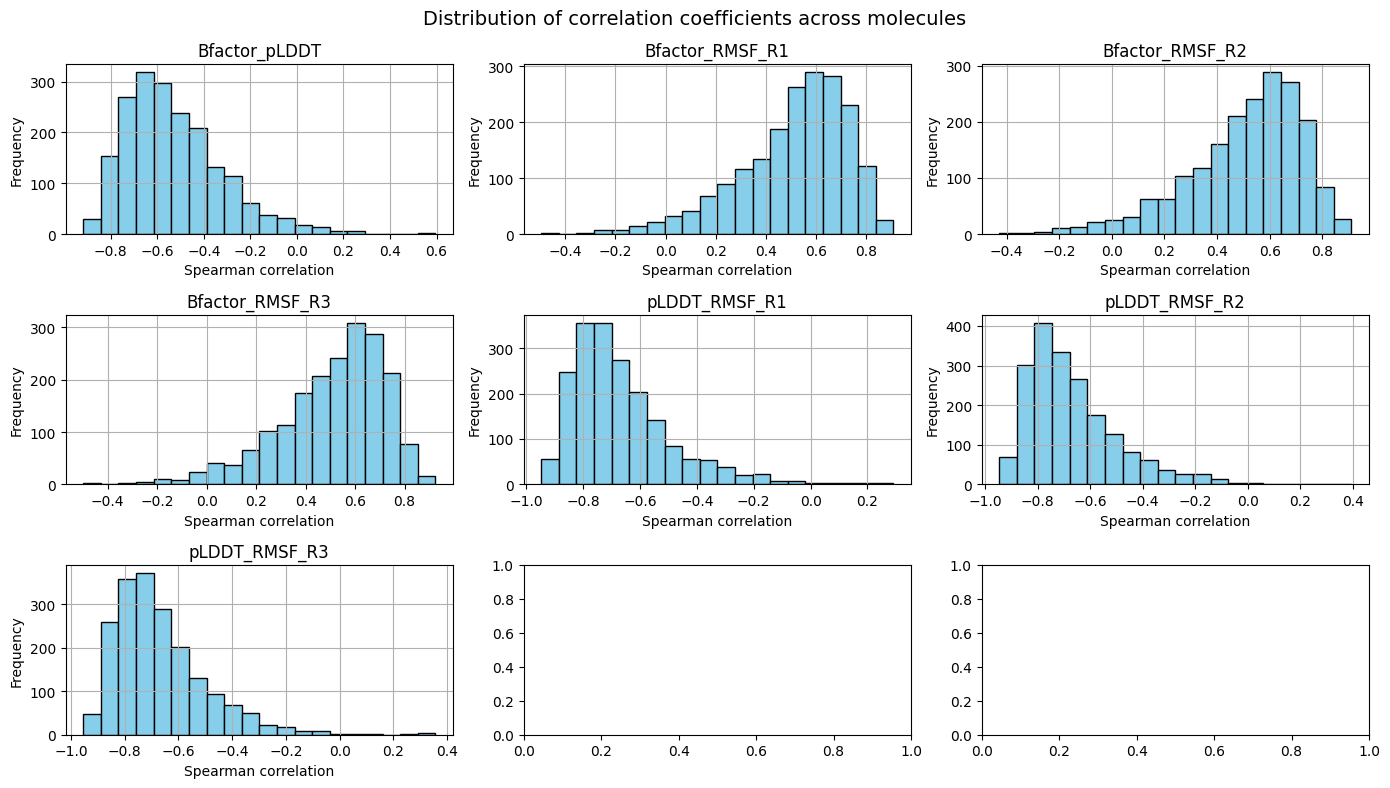

In [6]:
# Plot histograms for correlation distributions
fig, axes = plt.subplots(3, 3, figsize=(14, 8))

# Select only numeric columns (skip 'mol')
numeric_cols = corr_df.select_dtypes(include='number').columns

for ax, col in zip(axes.ravel(), numeric_cols):
    ax.hist(corr_df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Spearman correlation')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.suptitle('Distribution of correlation coefficients across molecules', fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt

# Collect correlation + molecule length info
summary_data = []

for mol, data in atlas_data.items():
    corr = data['corr_mat']
    mol_len = data['mol_len']
    try:
        summary_data.append({
            'mol': mol,
            'mol_len': mol_len,
            'pLDDT_RMSF_R1': corr.loc['pLDDT', 'RMSF_R1'],
            'pLDDT_RMSF_R2': corr.loc['pLDDT', 'RMSF_R2'],
            'pLDDT_RMSF_R3': corr.loc['pLDDT', 'RMSF_R3']
        })
    except KeyError:
        # skip incomplete correlations
        continue

summary_df = pd.DataFrame(summary_data)
print(summary_df.head())


      mol  mol_len  pLDDT_RMSF_R1  pLDDT_RMSF_R2  pLDDT_RMSF_R3
0  16pk_A      415      -0.489522      -0.474107      -0.371741
1  1a62_A      130      -0.803851      -0.703783      -0.647406
2  1ab1_A       46      -0.759919      -0.835755      -0.808443
3  1af7_A      274      -0.596054      -0.632525      -0.597743
4  1ah7_A      245      -0.638981      -0.778295      -0.634399


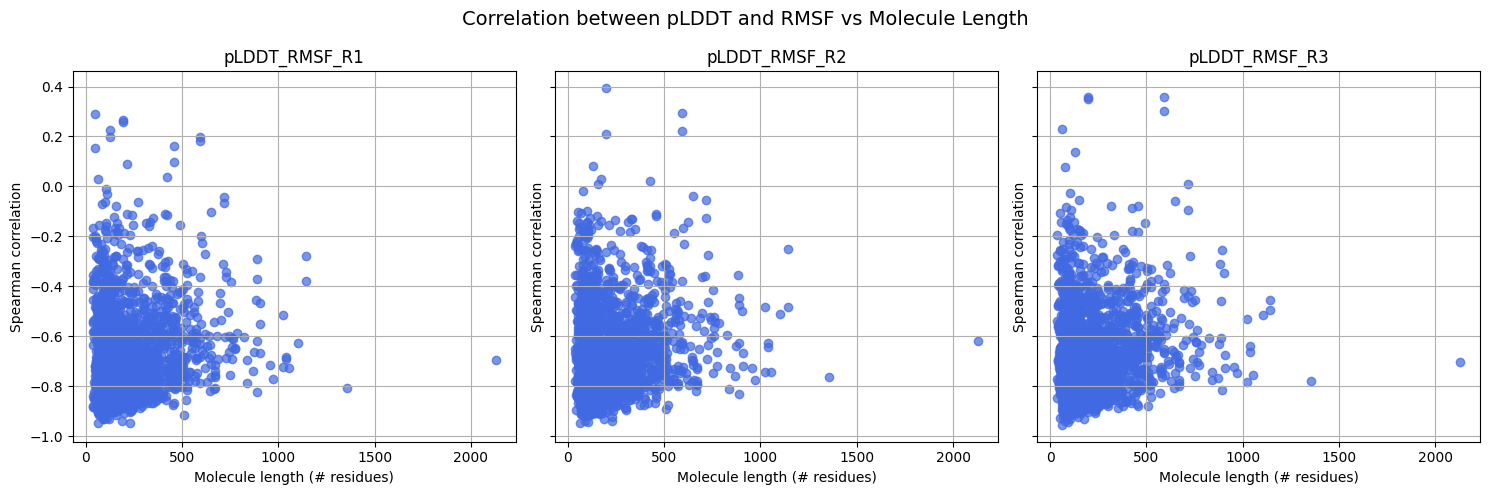

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, col in enumerate(['pLDDT_RMSF_R1', 'pLDDT_RMSF_R2', 'pLDDT_RMSF_R3']):
    axes[i].scatter(summary_df['mol_len'], summary_df[col], color='royalblue', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Molecule length (# residues)')
    axes[i].set_ylabel('Spearman correlation')
    axes[i].grid(True)

plt.suptitle('Correlation between pLDDT and RMSF vs Molecule Length', fontsize=14)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
from scipy.stats import kruskal

scope = pd.read_csv('2023_03_09_ATLAS_info.tsv', sep='\t')
scope = scope[['PDB', 'SCOP_renum_delineation']]

test_results = {}

counter = 0

for i, row in scope.iterrows():
    scop_domains = row['SCOP_renum_delineation'].replace(' ', '').split(',')
    n_scope_domains = len(scop_domains)
    if n_scope_domains != 2:
        continue
    mol = row['PDB']
    mol_len = atlas_data[mol]['mol_len']
    if mol_len < 100:
        continue
    rmsf1 = atlas_data[mol]['rmsf']['RMSF_R1']
    rmsf2 = atlas_data[mol]['rmsf']['RMSF_R2']
    rmsf3 = atlas_data[mol]['rmsf']['RMSF_R3']

    for domain in scop_domains:
        domain_range = domain.split('-')
        domain_start = int(domain_range[0])
        domain_end = int(domain_range[1])

        domain_rmsf1 = rmsf1[domain_start-1:domain_end-1]
        domain_rmsf2 = rmsf2[domain_start-1:domain_end-1]
        domain_rmsf3 = rmsf3[domain_start-1:domain_end-1]

        stat, p_value = kruskal(domain_rmsf1, domain_rmsf2, domain_rmsf3)
        if p_value < 0.05:
            test_results[mol] = {
                'statistic': stat,
                'p_value': p_value
            }
        else:
            counter += 1
print(f'Number of non-significant results: {counter}')
print(f'Number of significant results: {len(test_results)}')

Number of non-significant results: 48
Number of significant results: 109


In [ ]:
import subprocess
import os
import sys

venv_python = r"C:\Users\mihar\Desktop\MPBF\venv\Scripts\python.exe"

for mol in test_results.keys():
    output_dir = f"results/{mol}"
    pdb, chain = mol.split('_')
    os.makedirs(output_dir, exist_ok=True)

    cmd = [
        venv_python, 
        "SWORD2/SWORD2.py",
        "-p", pdb,
        "-c", chain,
        "-o", output_dir
    ]

    print("Running:", " ".join(cmd))

    completed = subprocess.run(
        cmd,
        capture_output=True,
        text=True
    )

    print("STDOUT:")
    print(completed.stdout)
    print("STDERR:")
    print(completed.stderr)

    if completed.returncode != 0:
        print(f"SWORD2 failed for {mol} with return code {completed.returncode}")


Running: C:\Users\mihar\Desktop\MPBF\venv\Scripts\python.exe SWORD2/SWORD2.py -p 1r6w -c A -o results/1r6w_A
STDOUT:

STDERR:
2026/01/07 09:32:30 INFO     Fetch PDB ID: 1r6w
2026/01/07 09:32:30 INFO     Downloading PDB files via FTP failed, trying HTTP.
2026/01/07 09:32:31 WARNING  WARNING Results dir 'results/1r6w_A\1r6w_A' already exists --> New results dir 'results/1r6w_A\1r6w_A_07_01_2026_50689'
2026/01/07 09:32:31 INFO     
2026/01/07 09:32:31 INFO     >>>   1r6w_A (321 aa)
2026/01/07 09:32:31 INFO     >>>   Estimated runtime: 1 minutes and 4 seconds
2026/01/07 09:32:31 INFO     >>>   Using 16 cpus
2026/01/07 09:32:31 INFO     
2026/01/07 09:32:31 INFO     Write a clean version of the PDB: remove non standard residues
2026/01/07 09:32:31 INFO     Launch SWORD
Traceback (most recent call last):
  File "c:\Users\mihar\Desktop\MPBF\SWORD2\SWORD2.py", line 1036, in <module>
    subprocess.run(SWORD, capture_output=True)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\m

KeyboardInterrupt: 